In [1]:
import warnings
import scanpy as sc
import decoupler as dc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import json
import os
from tqdm.notebook import tqdm

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

## Global variables

In [2]:
results_dir = 'data/pseudobulks'
os.makedirs(results_dir, exist_ok=True)

In [3]:
dir_path = 'data/filtered_adata/'

In [4]:
os.listdir(dir_path)

['chimp.h5ad', 'human.h5ad', 'macaque.h5ad', 'spatial_libd_human.h5ad']

## Utility functions

In [5]:
def subtract_mean(adata: an.AnnData, output_layer: str = "mean_norm") -> an.AnnData:
    adata_new = adata.copy()

    # 1. Compute gene-wise means for every sample  (shape: n_samples × n_genes)
    sample_ids = adata.obs["sample_id"].astype("category")
    gene_means = (
        pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
          .groupby(sample_ids).mean()                     # rows → samples
          .loc[sample_ids]                                # align back to cells
          .to_numpy()                                     # same order as adata.obs
    )

    # 2. Subtract in one shot (broadcasting) – no views, no loops
    adata_new.layers[output_layer] = adata.X - gene_means.astype(adata.X.dtype)

    return adata_new

# Calculate pseudobulks

## Calculate pseudobulks for each species

In [6]:
pseudobulk_dict = dict()
mode = 'mean'
for file_name in tqdm(os.listdir(dir_path)):
    file = file_name.split('.')[0]
    # read visium data
    adata = sc.read_h5ad(dir_path + file_name)
    adata.obs.index = adata.obs.sample_id.astype(str) + "-" + adata.obs.index.astype(str)
    adata.obs.label.replace({"L6a": "L6", "L6b": "L6"}, inplace=True)
    adata.obs['condition'] = file
    # calculate pseudobulks
    pdata = dc.pp.pseudobulk(
    adata,
    sample_col='sample_id',
    groups_col='label',
    mode=mode
    )
    # save files
    pdata.obs['condition'] = file
    pdata.obs = pdata.obs[['label', 'sample_id', 'psbulk_cells', 'psbulk_counts', 'condition']]
    pdata.obs.columns = ['layer', 'sample_id', 'psbulk_cells', 'psbulk_counts', 'condition']
    pseudobulk_dict[file] = pdata[pdata.X.sum(axis=1) > 0, :].copy()
    pdata.write_h5ad(f'{results_dir}/pb_{file}.h5ad')
    print(f'Pseudobulk {file} saved.')

  0%|          | 0/4 [00:00<?, ?it/s]

/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
... storing 'condition' as categorical


Pseudobulk chimp saved.


/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
... storing 'condition' as categorical


Pseudobulk human saved.


/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
... storing 'condition' as categorical


Pseudobulk macaque saved.


/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
... storing 'condition' as categorical


Pseudobulk spatial_libd_human saved.


## Combine pseudobulks

In [7]:
# Concat for newborn human, chimpanzee, and macaque
nb_mammals = an.concat([pseudobulk_dict['human'], pseudobulk_dict['chimp'], pseudobulk_dict['macaque']] , merge='same',uns_merge="unique")
nb_mammals

AnnData object with n_obs × n_vars = 94 × 15585
    obs: 'layer', 'sample_id', 'psbulk_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

In [8]:
# Concat for newborn and adult humans
humans = an.concat([pseudobulk_dict['human'], pseudobulk_dict['spatial_libd_human']] , merge='same',uns_merge="unique")
humans

AnnData object with n_obs × n_vars = 111 × 19404
    obs: 'layer', 'sample_id', 'psbulk_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

In [9]:
# Concat all four
pbadata = an.concat([pseudobulk_dict['human'], pseudobulk_dict['chimp'], pseudobulk_dict['macaque'], pseudobulk_dict['spatial_libd_human']] , merge='same',uns_merge="unique")
pbadata

AnnData object with n_obs × n_vars = 170 × 15367
    obs: 'layer', 'sample_id', 'psbulk_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

# Process pseudobulks

## Newborn pseudobulks

### Normalize on sequence depth

In [10]:
adata_pb = nb_mammals.copy()
adata_pb.layers["counts"] = adata_pb.X.copy()

In [11]:
sc.pp.normalize_total(adata_pb, target_sum=1e4)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:01)


... storing 'condition' as categorical


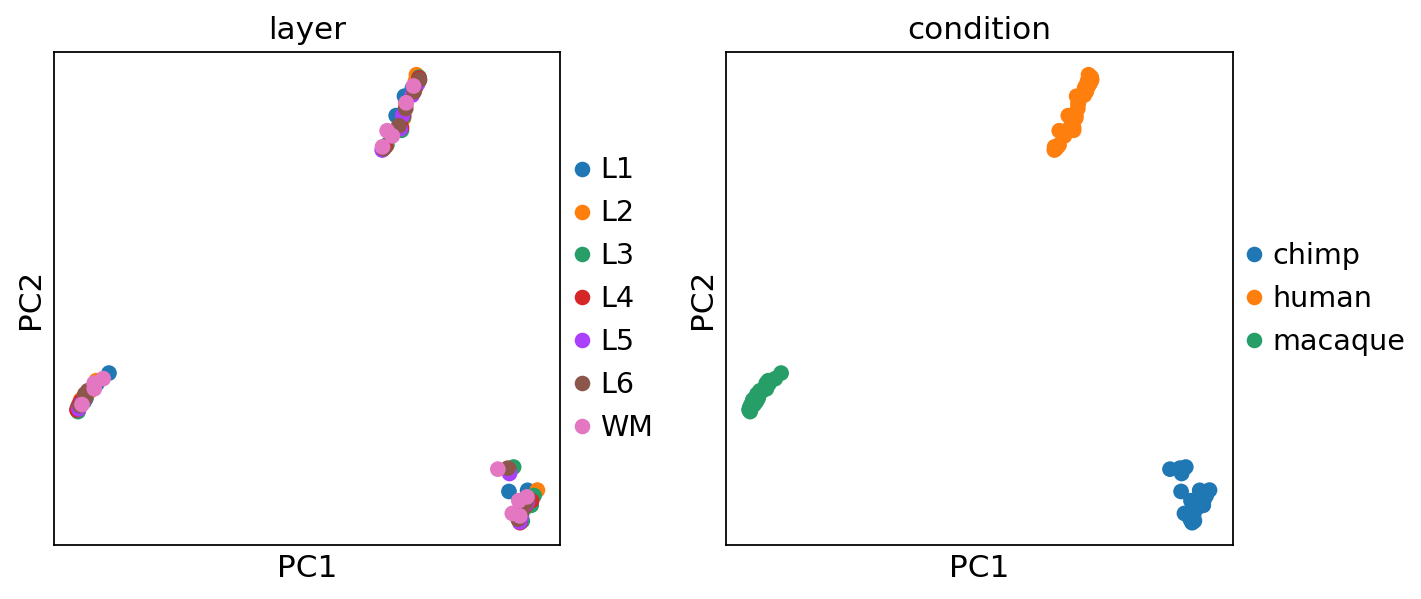

In [12]:
sc.pl.pca(adata_pb, color=['layer', 'condition'], size=200, ncols=2)

## Normalize on average expression level

In [13]:
adata_pb = subtract_mean(adata_pb, output_layer="mean_norm")
adata_pb

AnnData object with n_obs × n_vars = 94 × 15585
    obs: 'layer', 'sample_id', 'psbulk_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca', 'layer_colors', 'condition_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts', 'mean_norm'

In [14]:
sc.pp.pca(adata_pb, layer="mean_norm", key_added="X_pca_mean_norm")

computing PCA
    with n_comps=50
    finished (0:00:00)


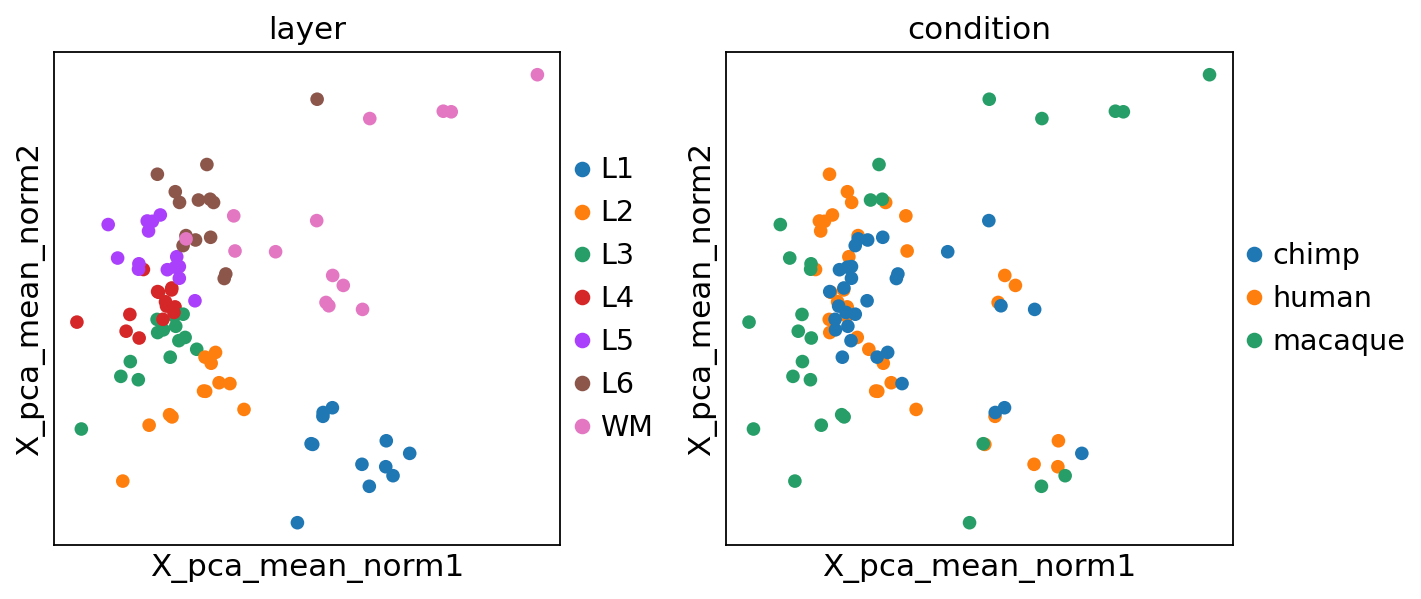

In [15]:
sc.pl.embedding(adata_pb, basis="X_pca_mean_norm", color=["layer", "condition"], size=150, ncols=2)

## Save pseudobulks

In [16]:
adata_pb.write_h5ad(f'{results_dir}/pseudobulk_all_mammals.h5ad')

## Adult and newborn human pseudobulks

### Normalize on sequence depth

In [17]:
adata_pb = humans.copy()
adata_pb.layers["counts"] = adata_pb.X.copy()

In [18]:
sc.pp.normalize_total(adata_pb, target_sum=1e4)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


... storing 'condition' as categorical


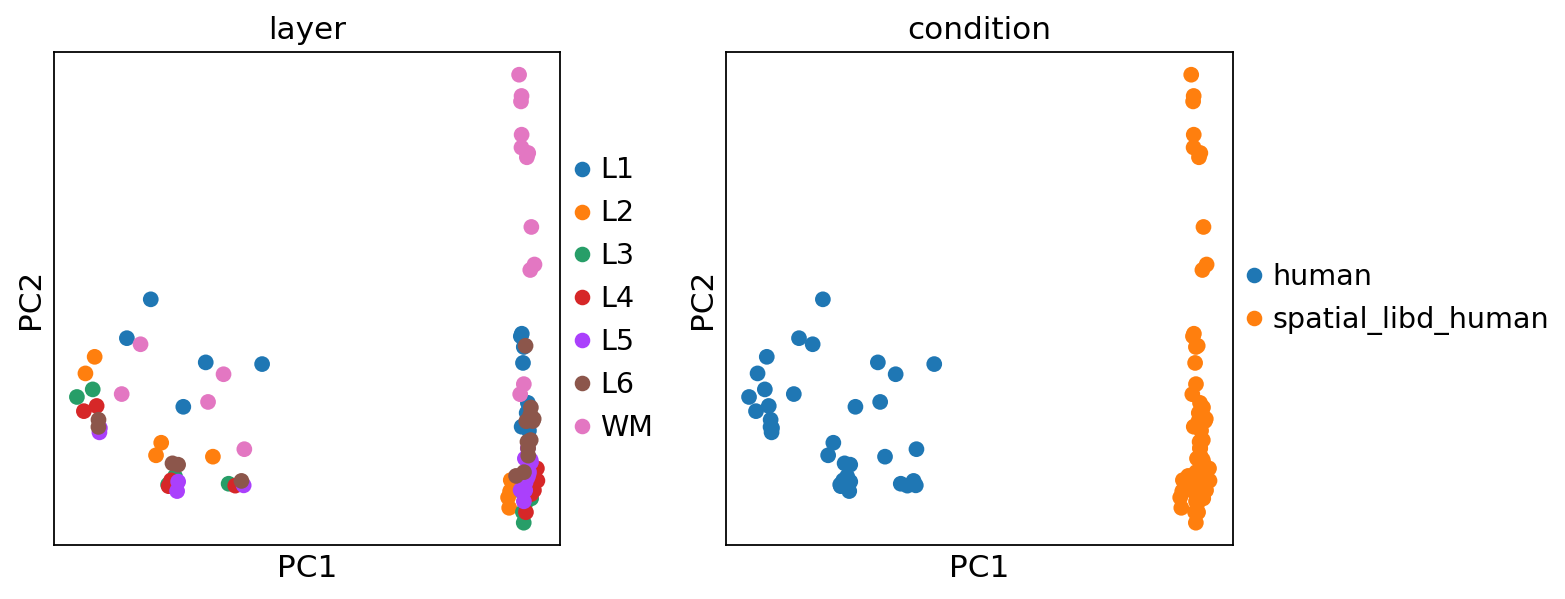

In [19]:
sc.pl.pca(adata_pb, color=['layer', 'condition'], size=200, ncols=2)

## Normalize on average expression level

In [20]:
adata_pb = subtract_mean(adata_pb, output_layer="mean_norm")
adata_pb

AnnData object with n_obs × n_vars = 111 × 19404
    obs: 'layer', 'sample_id', 'psbulk_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca', 'layer_colors', 'condition_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts', 'mean_norm'

In [21]:
sc.pp.pca(adata_pb, layer="mean_norm", key_added="X_pca_mean_norm")

computing PCA
    with n_comps=50
    finished (0:00:00)


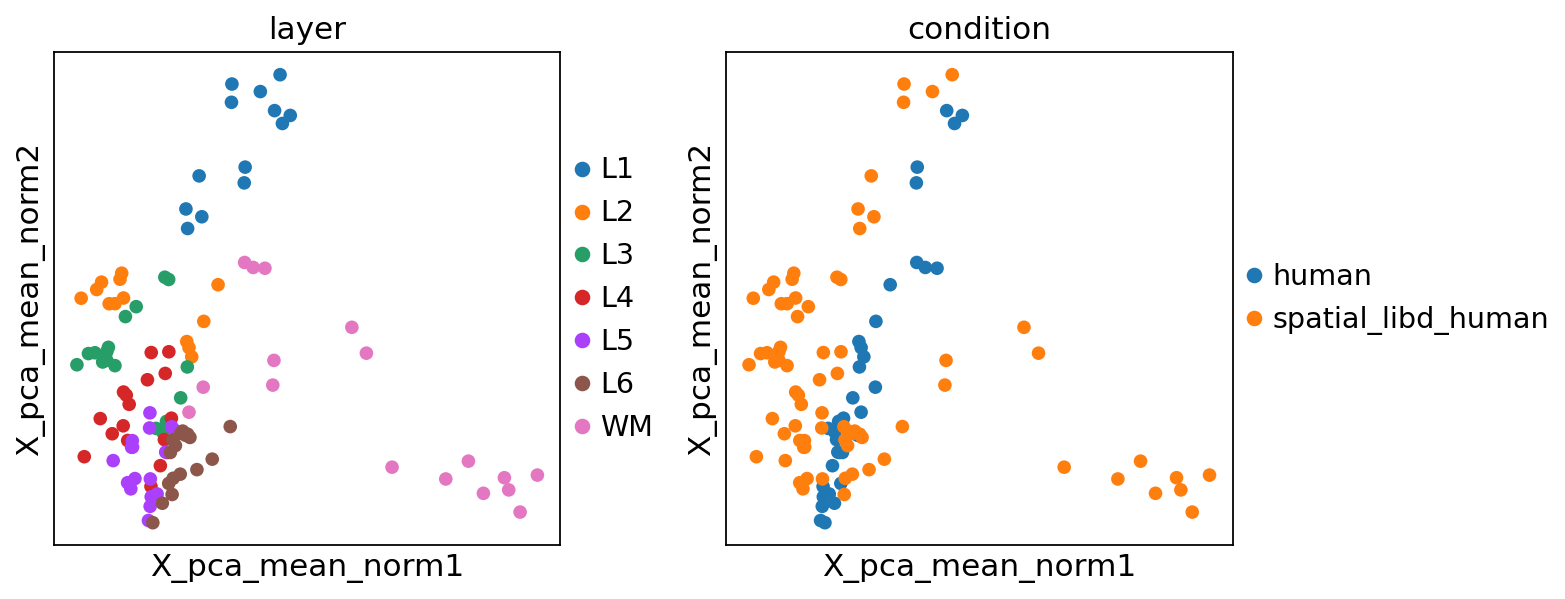

In [22]:
sc.pl.embedding(adata_pb, basis="X_pca_mean_norm", color=["layer", "condition"], size=150, ncols=2)

## Save pseudobulks

In [23]:
adata_pb.write_h5ad(f'{results_dir}/pseudobulk_humans.h5ad')

## All Four

### Normalize on sequence depth

In [24]:
adata_pb = pbadata.copy()
adata_pb.layers["counts"] = adata_pb.X.copy()

In [25]:
sc.pp.normalize_total(adata_pb, target_sum=1e4)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


... storing 'condition' as categorical


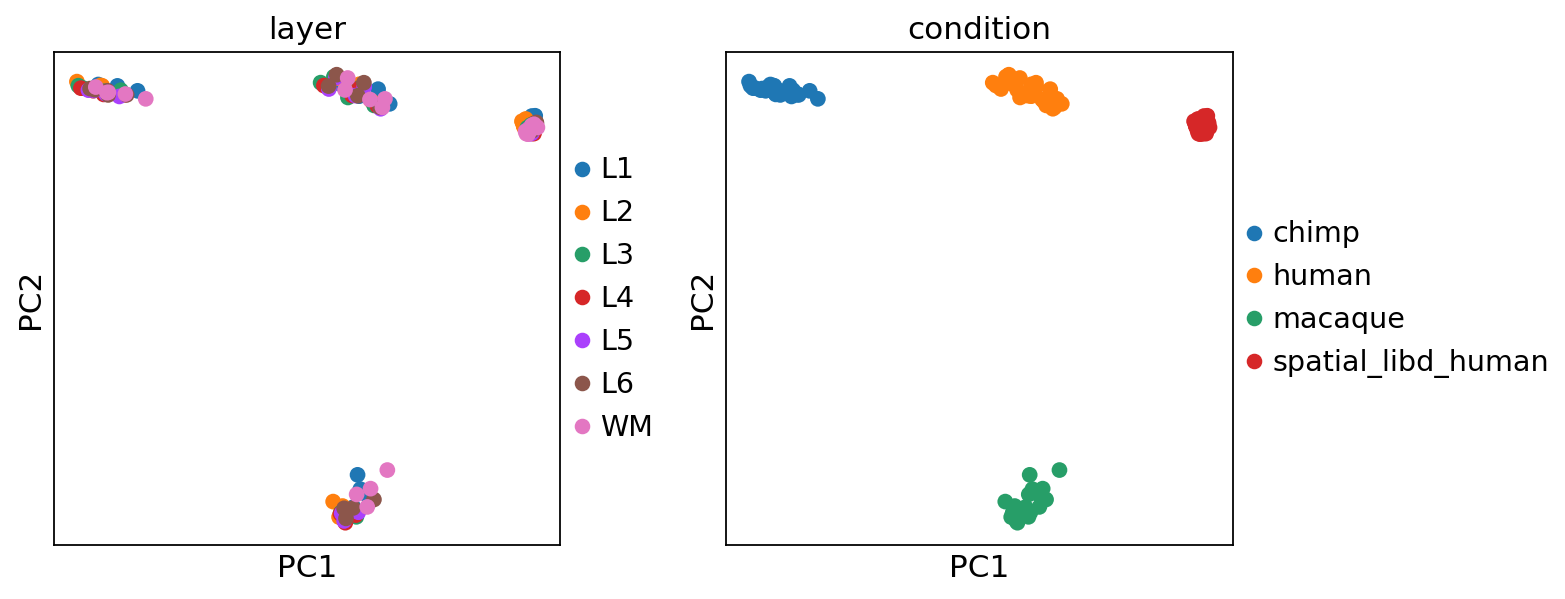

In [26]:
sc.pl.pca(adata_pb, color=['layer', 'condition'], size=200, ncols=2)

## Normalize on average expression level

In [27]:
adata_pb = subtract_mean(adata_pb, output_layer="mean_norm")
adata_pb

AnnData object with n_obs × n_vars = 170 × 15367
    obs: 'layer', 'sample_id', 'psbulk_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca', 'layer_colors', 'condition_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts', 'mean_norm'

In [28]:
sc.pp.pca(adata_pb, layer="mean_norm", key_added="X_pca_mean_norm")

computing PCA
    with n_comps=50
    finished (0:00:00)


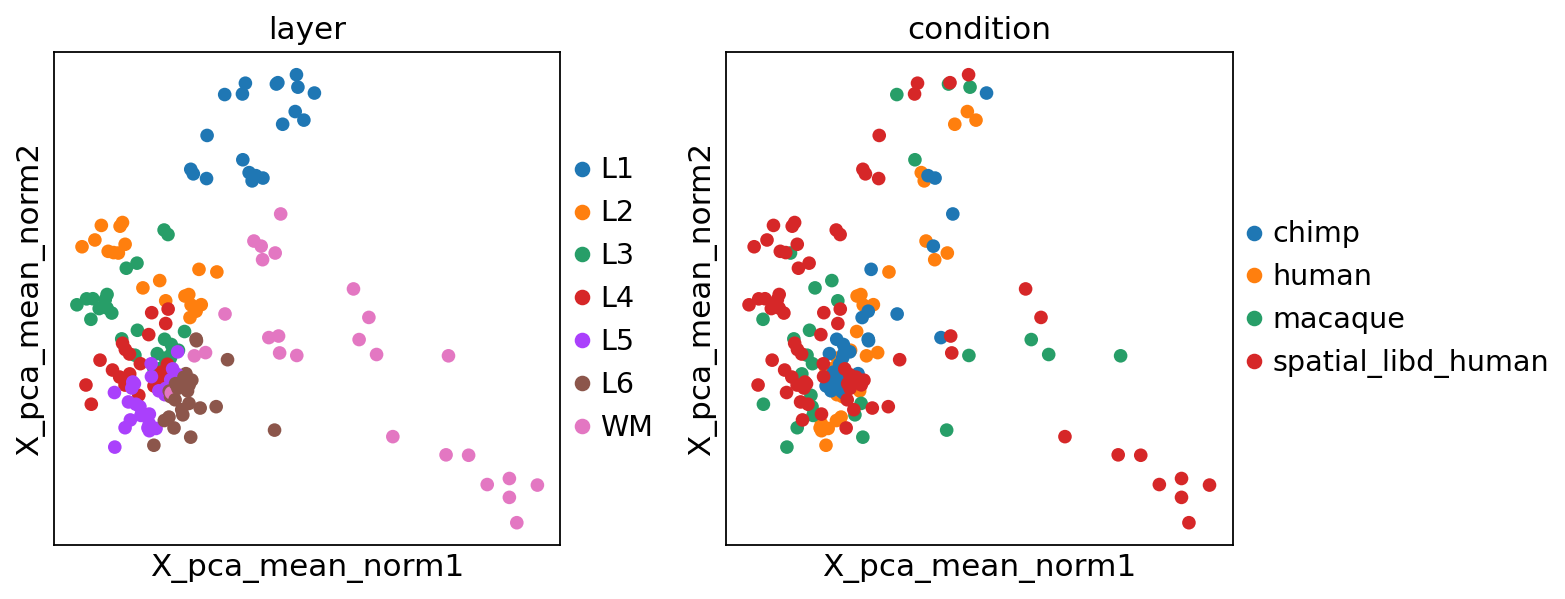

In [29]:
sc.pl.embedding(adata_pb, basis="X_pca_mean_norm", color=["layer", "condition"], size=150, ncols=2)

## Save pseudobulks

In [30]:
adata_pb.write_h5ad(f'{results_dir}/pseudobulk_all_four.h5ad')